In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import pandas as pd

In [124]:
def center_of_mass(data):
    normalized_data = data / np.max(data)
    y, x = np.ogrid[0 : data.shape[-2], 0 : data.shape[-1]]
    while len(data.shape) > len(x.shape):
        x = np.expand_dims(x, axis=0)
        y = np.expand_dims(y, axis=0)
    first_moment_x = x * normalized_data
    first_moment_y = y * normalized_data
    mean_mass = np.mean(normalized_data, axis=(-2, -1))
    return (np.mean(first_moment_x, axis=(-2, -1)) / mean_mass,
            np.mean(first_moment_y, axis=(-2, -1)) / mean_mass)

def get_photometry_magnitude(
        data, center, radius_min=2, radius_max=30, gain=1, readnoise=1):
    y, x = np.ogrid[0 : data.shape[-2], 0 : data.shape[-1]]
    dist = np.sqrt((x - center[0])**2 + (y - center[1])**2)

    max_snr = 0
    snrs = []
    radiuss = []
    for radius in range(radius_min, radius_max + 1):
        star_data = data[dist <= radius]
        sum_brightness = np.sum(star_data)
        background_data = (data[(2 * radius < dist) & (dist < 3 * radius)])
        background_brightness = np.median(background_data) * len(star_data)
        background_noise = sum_brightness
    
        corrected_brightness = sum_brightness - background_brightness
        noise = np.sqrt(
            (background_noise / gain)
            + (len(star_data) * readnoise)**2)
        snr = corrected_brightness / gain / noise

        if snr > max_snr:
            max_snr = snr
            best_radius = radius
            best_brightness = corrected_brightness
        snrs.append(snr)
        radiuss.append(radius)

    plt.figure(figsize=(8, 6))
    plt.scatter(radiuss, snrs, color='blue', label='Data')
    plt.plot(radiuss, snrs, 'r--')
    plt.xlabel("Radius")
    plt.ylabel("SNR")
    plt.title("SNR VS Radius")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_uncertainty = 1.08 / max_snr
    return -2.5 * np.log10(best_brightness), best_uncertainty, best_radius, max_snr, best_brightness

# PSF

In [69]:
#centeroid finder
def centeroid(pic):
    x_len, y_len = pic.shape
    c_cord = np.array([0,0])
    weight = np.sum(pic)
    for i in range(x_len):
        for j in range(y_len):
            c_cord[0] += pic[i][j]*i
            c_cord[1] += pic[i][j]*j       
    return c_cord[0]//weight , c_cord[1]//weight

#crop_around
def crop_around(stars_img, star_x, star_y):
    return stars_img[star_y-30: star_y+30].T[star_x-30: star_x+30].T

#bad pixel removal
def bad_pix_rem(star_img):
    for i in range(1,59):
        for j in range(1,59):
            nhood=np.array([star_img[i-1][j],star_img[i-1][j-1],star_img[i-1][j+1],star_img[i][j-1],star_img[i][j+1],
                            star_img[i+1][j],star_img[i+1][j-1],star_img[i+1][j+1]])
            nhood_med=np.median(nhood)
            if star_img[i][j]>200 + nhood_med:
                star_img[i][j]=nhood_med
    return star_img

In [159]:
import math

def ra_to_degrees(hours, minutes, seconds):
    return 15 * (hours + minutes / 60 + seconds / 3600)

def dec_to_degrees(degrees, arcminutes, arcseconds):
    sign = -1 if degrees < 0 else 1
    return sign * (abs(degrees) + arcminutes / 60 + arcseconds / 3600)

def angular_separation(ra1_deg, dec1_deg, ra2_deg, dec2_deg):
    # Convert degrees to radians
    ra1 = math.radians(ra1_deg)
    dec1 = math.radians(dec1_deg)
    ra2 = math.radians(ra2_deg)
    dec2 = math.radians(dec2_deg)

    # spherical cosine formula
    cos_theta = (math.sin(dec1) * math.sin(dec2) +
                 math.cos(dec1) * math.cos(dec2) * math.cos(ra1 - ra2))

    cos_theta = max(min(cos_theta, 1.0), -1.0)  
    theta_rad = math.acos(cos_theta)

    return math.degrees(theta_rad) * 3600  # Convert radians to arcseconds

# Star 1: 17h47m42.08s, +5°41'15.2"
ra1_deg = ra_to_degrees(17, 47, 42.08)
dec1_deg = dec_to_degrees(5, 41, 15.2)

# Star 2: 17h47m12.36s, +5°40'52.4"
ra2_deg = ra_to_degrees(17, 47, 12.36)
dec2_deg = dec_to_degrees(5, 40, 52.4)

# angular separation
sep_arcsec = angular_separation(ra1_deg, dec1_deg, ra2_deg, dec2_deg)
print(f"Angular separation: {sep_arcsec:.2f} arcseconds")


Angular separation: 444.19 arcseconds


In [ ]:
data = fits.open('Teymoori_Talebi_1688_1275_V_IC-4665_29x2s_iso800_Newton8_NikonD90_20250424_Bahram.fits')[0].data

reference_center = center_of_mass(data[1690:1730, 1164:1211])
reference_center_ref = (reference_center[0] + 1164, reference_center[1] + 1690)
reference_mag = 7.36

star1_center = center_of_mass(data[1518:1548, 1000:1034])
star1_center_ref = (star1_center[0] + 1000, star1_center[1] + 1518)

star2_center = center_of_mass(data[ 1623:1658, 1374:1413])
star2_center_ref = (star2_center[0] + 1374, star2_center[1] + 1623)

stars_pixel_distance = np.sqrt(
    (star1_center_ref[0] - star2_center_ref[0])**2
    + (star1_center_ref[1] - star2_center_ref[1])**2)

arcsec_per_pixel = sep_arcsec / stars_pixel_distance
arcsec_per_pixel_error = 0.5 / stars_pixel_distance * np.sqrt(
    1 + 2 * arcsec_per_pixel**2)
arcsec_squared_per_pixel = arcsec_per_pixel**2
arcsec_squared_per_pixel_error = 2 * arcsec_per_pixel * arcsec_per_pixel_error

print(f"Arc seconds per pixel: {arcsec_per_pixel}")
print(f"Arc seconds per pixel error: {arcsec_per_pixel_error}")

Arc seconds per pixel: 1.131909242768147
Arc seconds per pixel error: 0.0024048231990101946


In [161]:
#initializion 

starsss=pd.read_csv("stars.csv")
loc_x = np.array(starsss["x0"].tolist())
loc_y = np.array(starsss["y0"].tolist())
img_len_y, img_len_x = data.shape

sigma_hist=np.array([])
delta_sigma_hist=np.array([])

In [162]:
img_len_x, img_len_y

(3378, 2557)

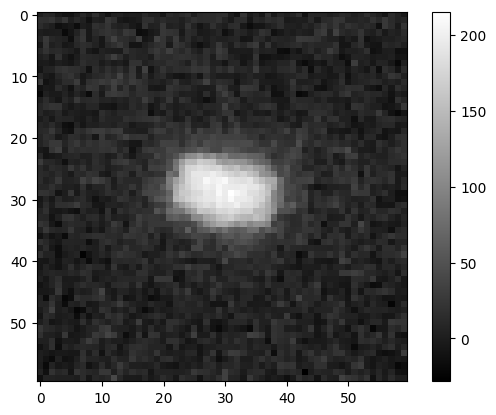

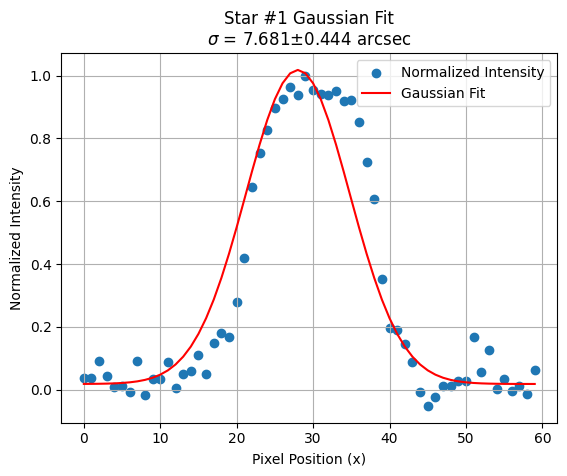

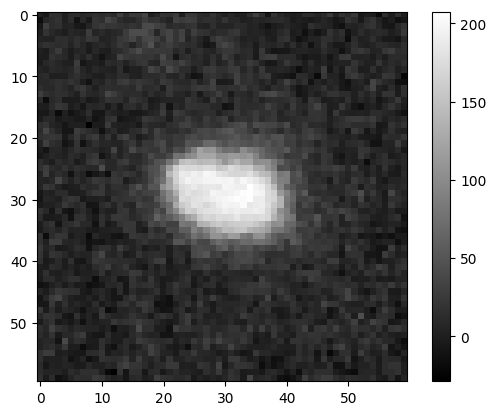

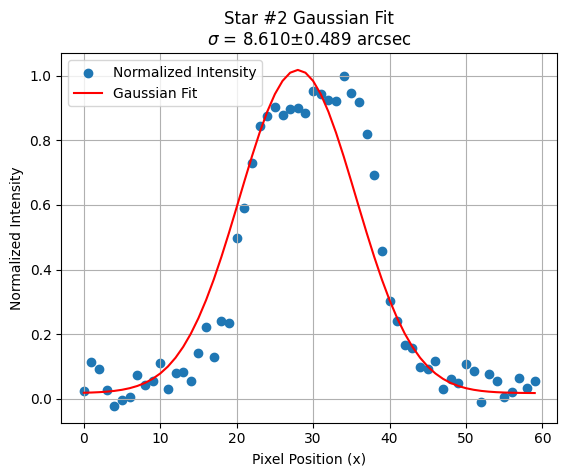

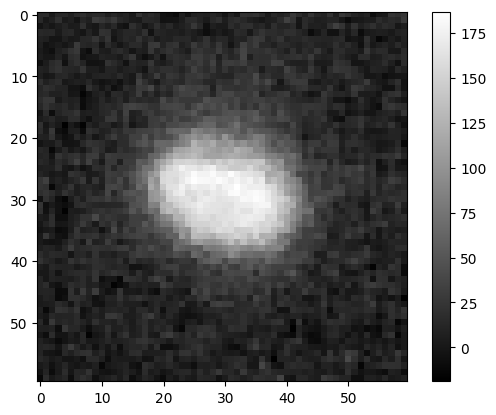

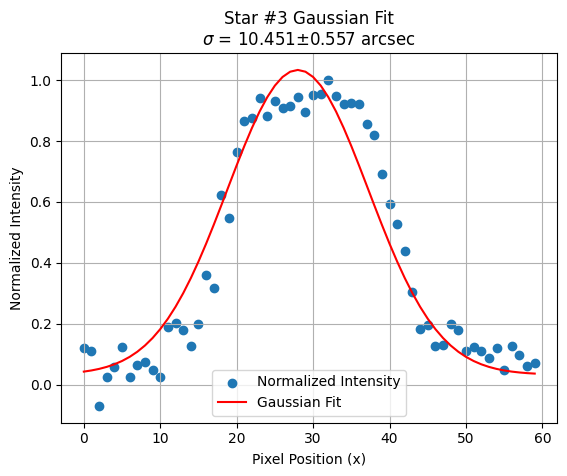

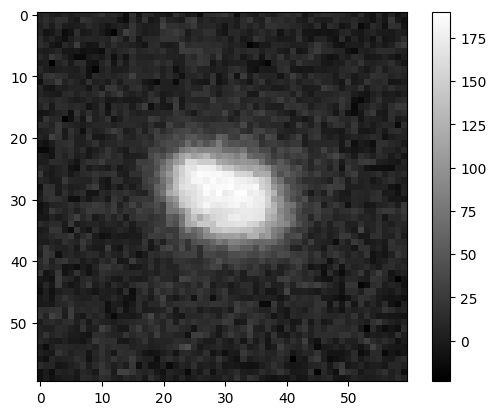

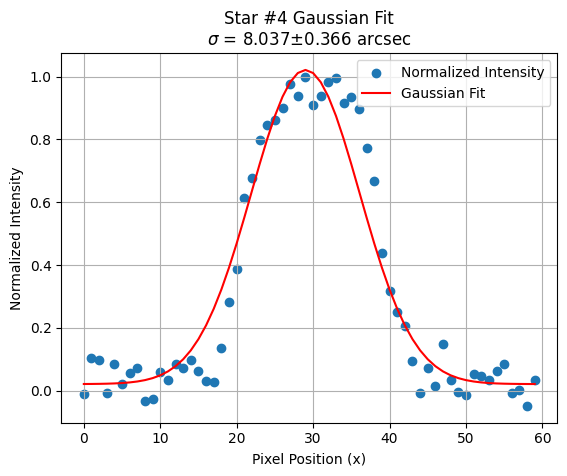

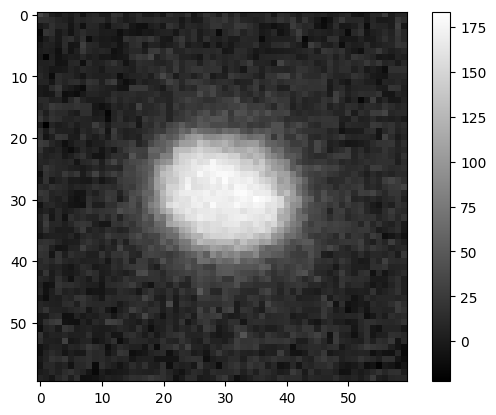

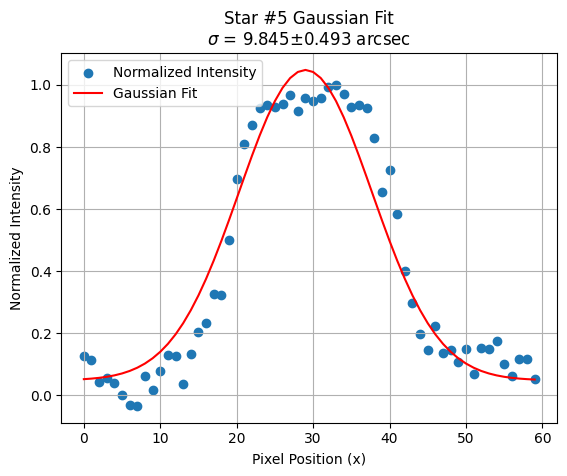

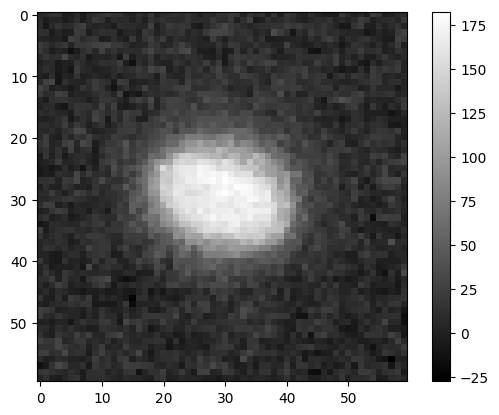

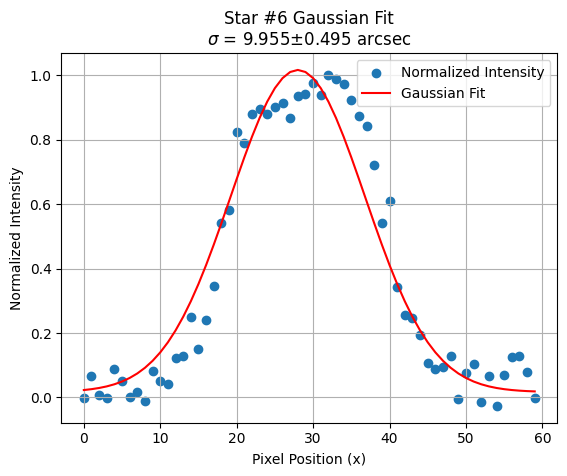

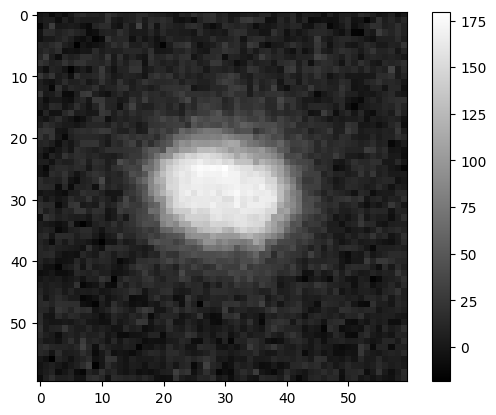

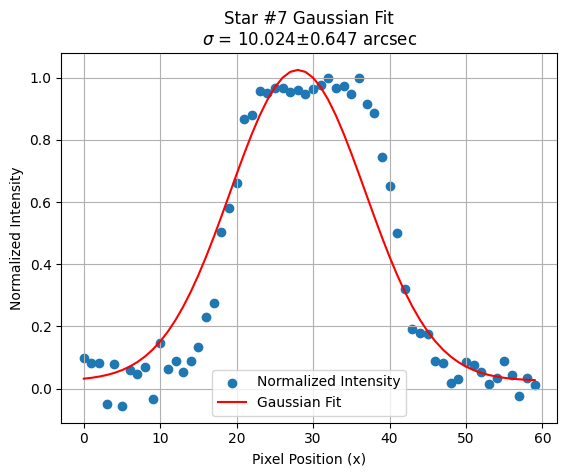

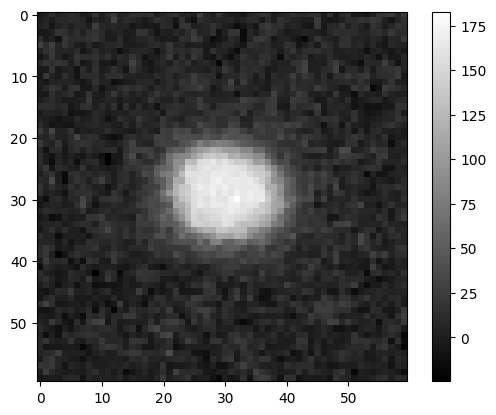

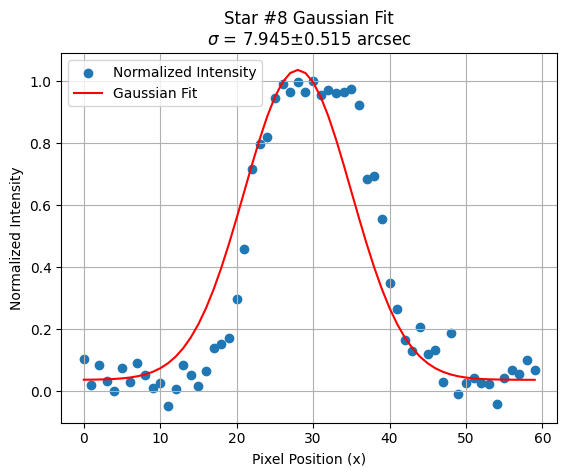

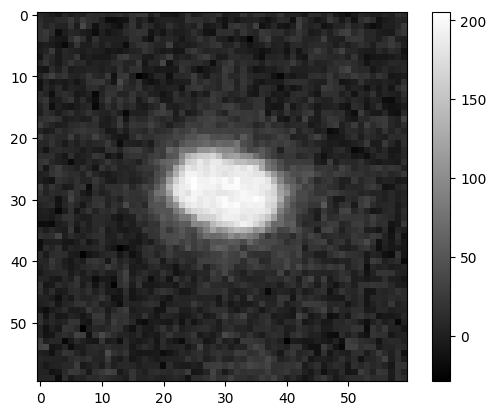

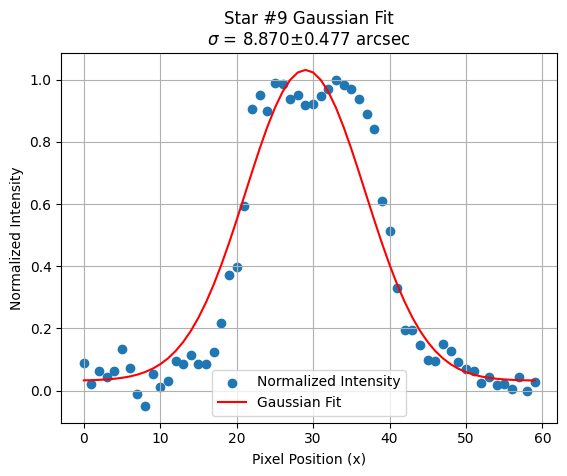

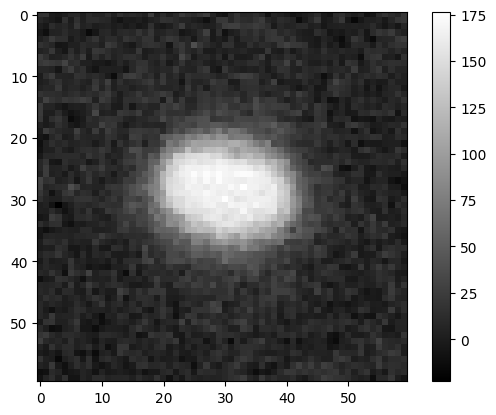

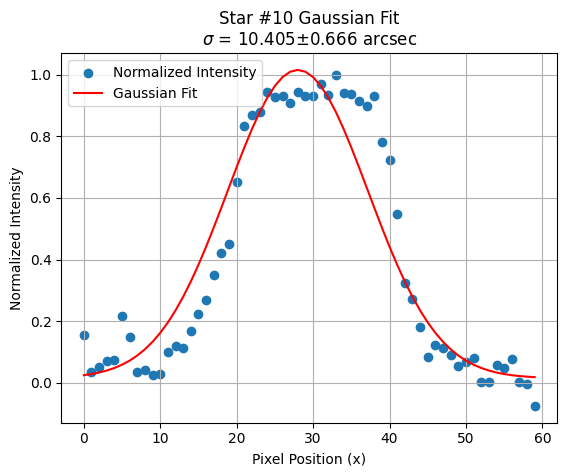

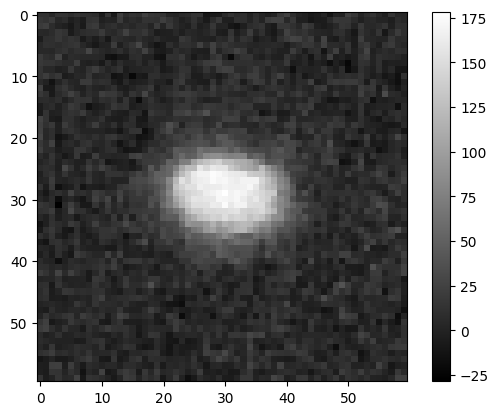

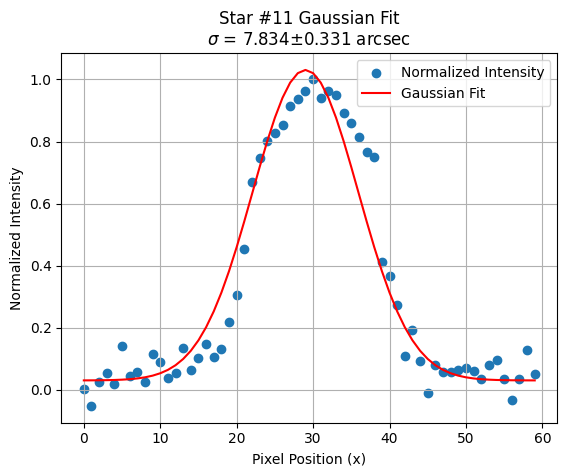

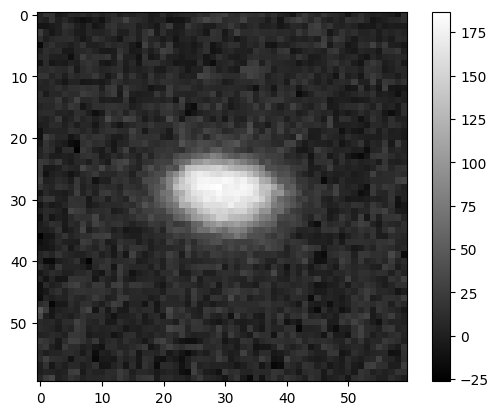

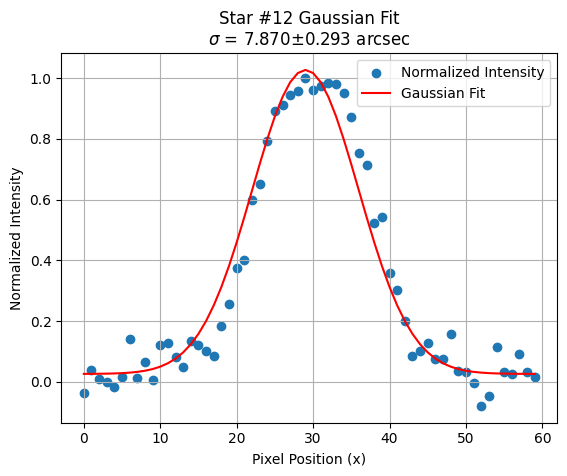

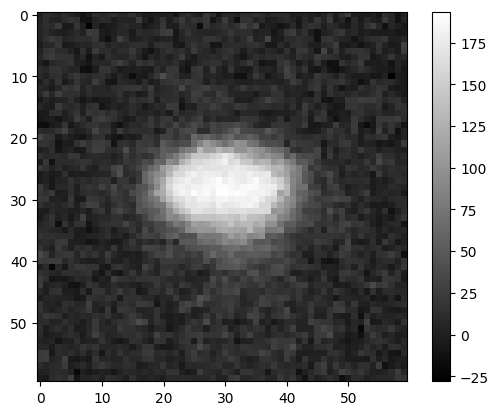

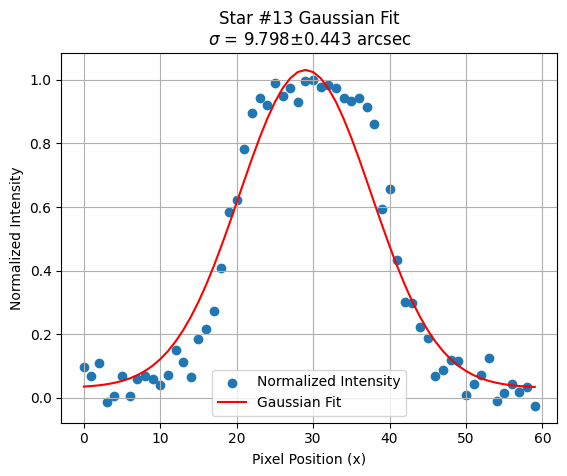

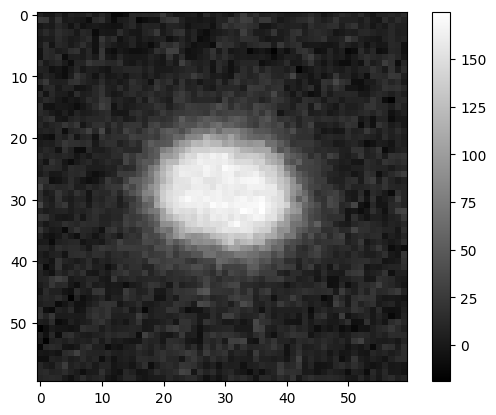

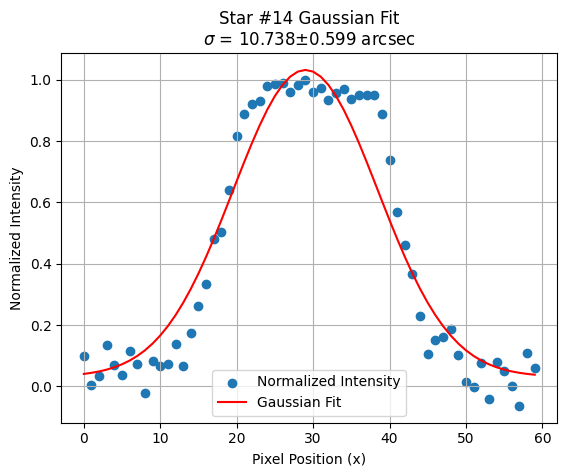

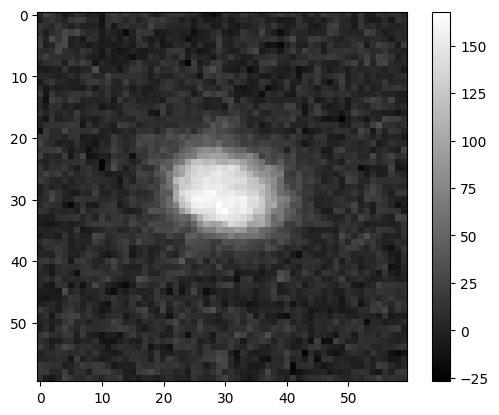

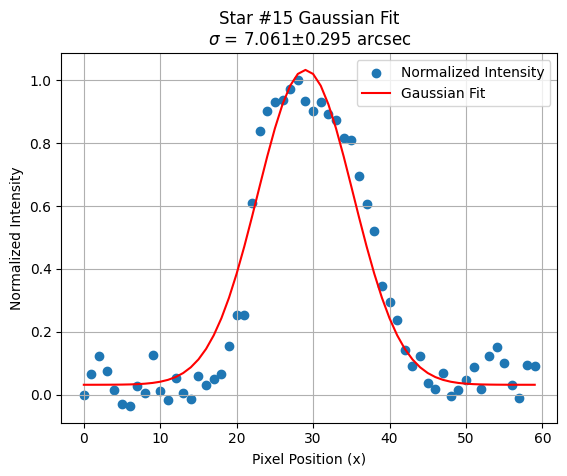

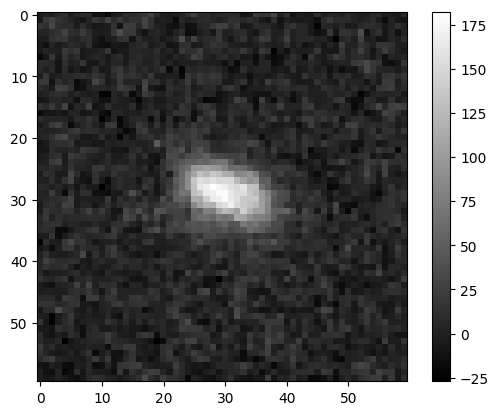

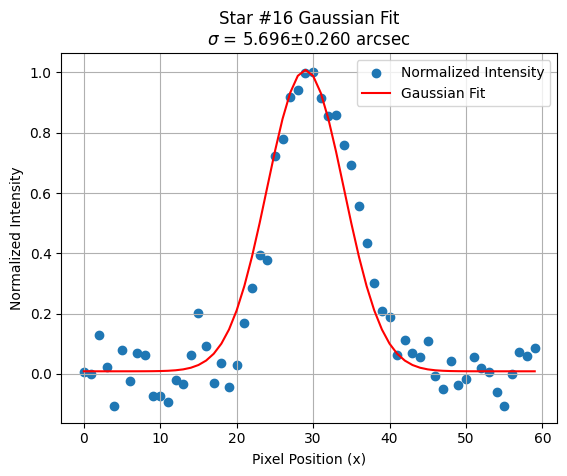

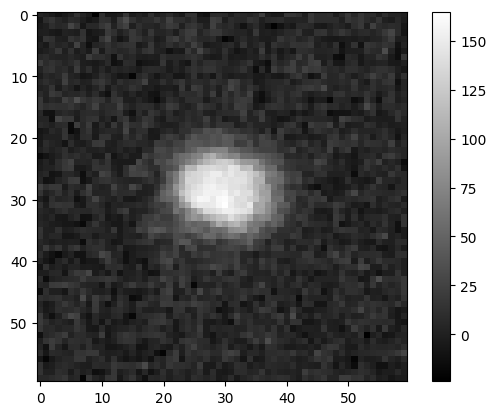

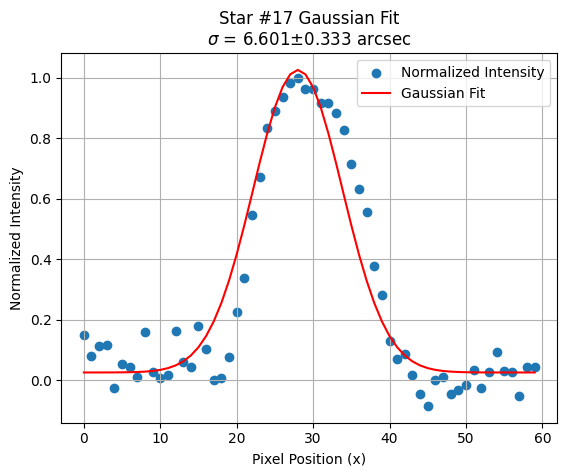

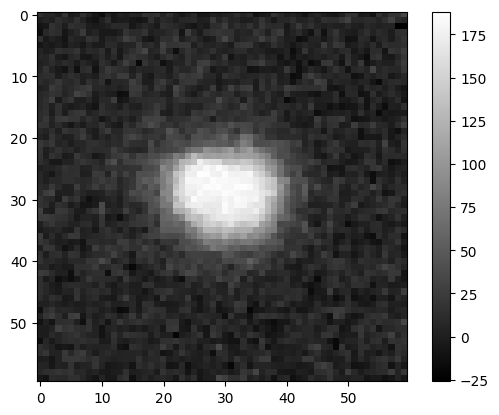

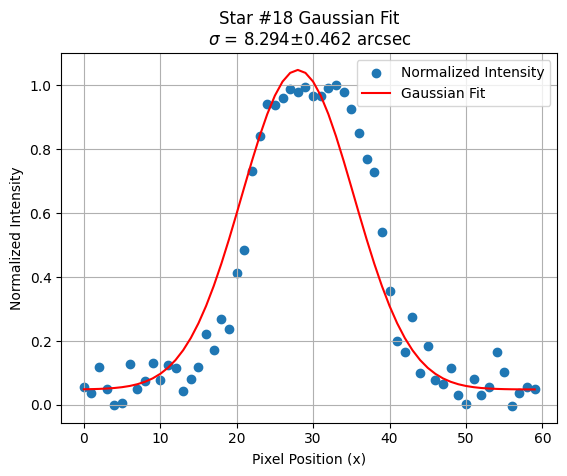

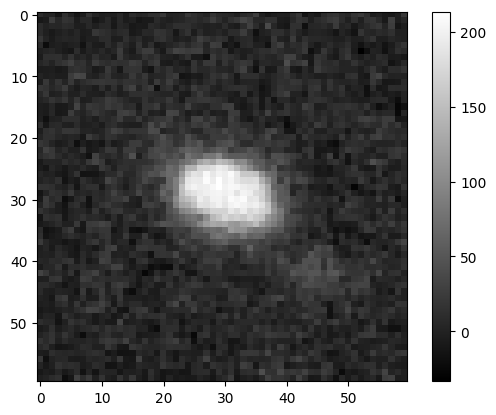

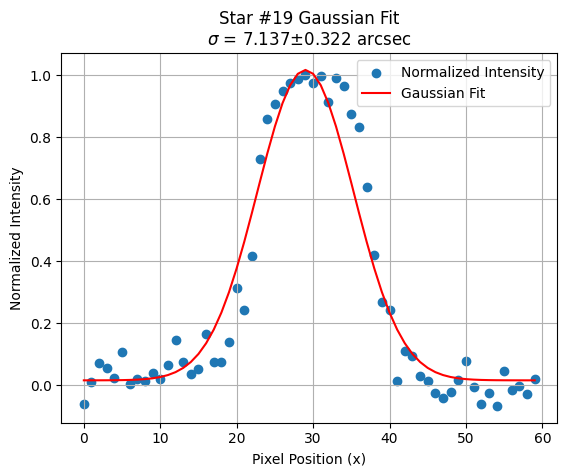

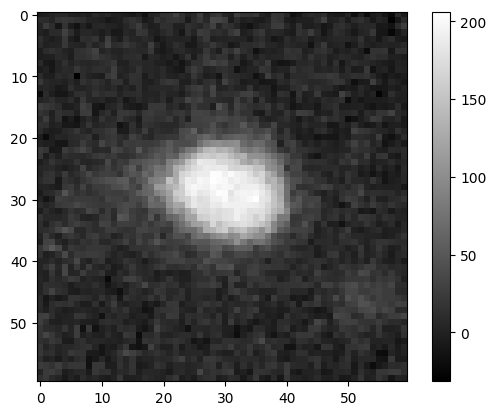

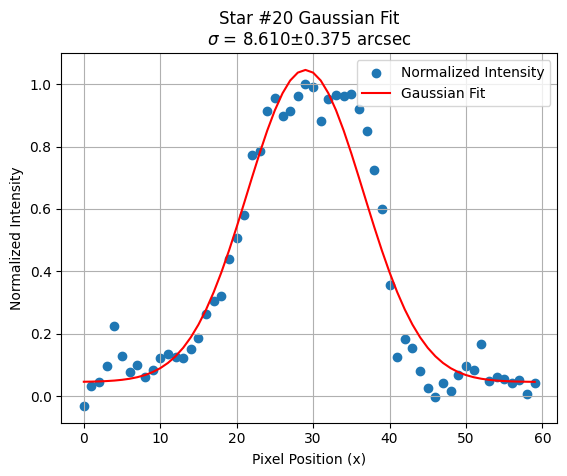

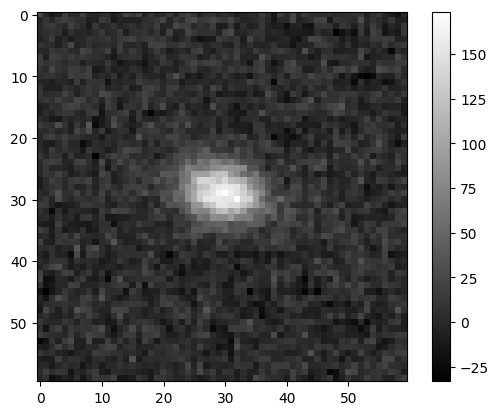

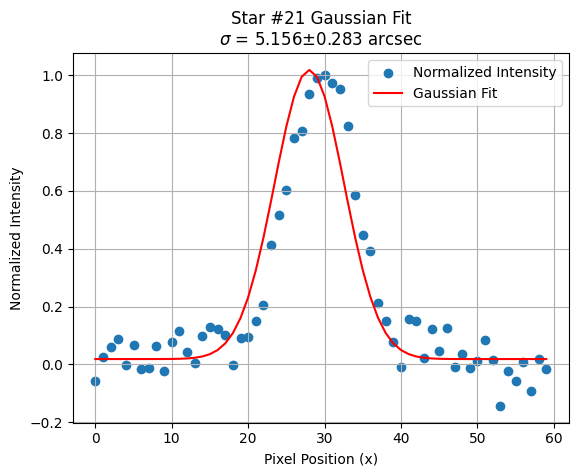

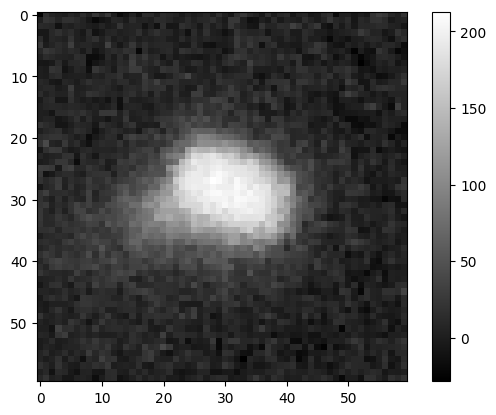

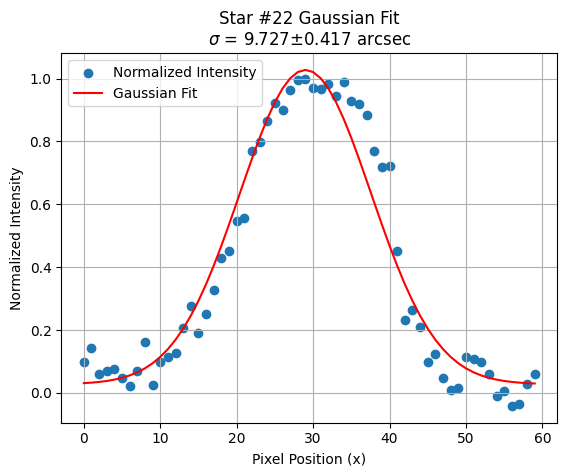

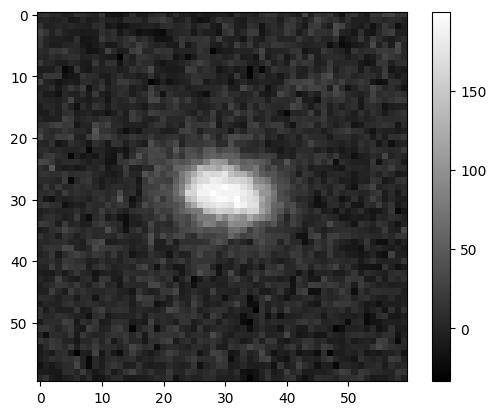

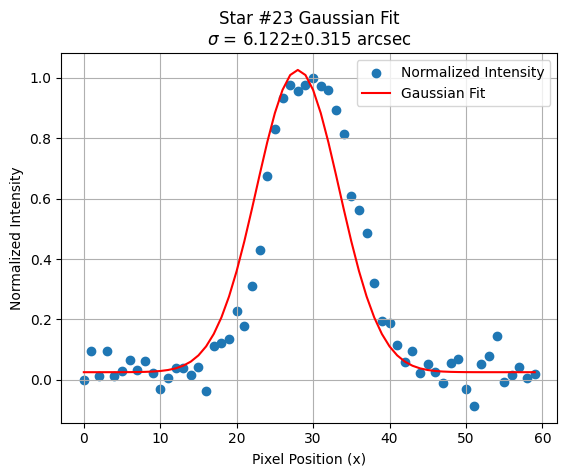

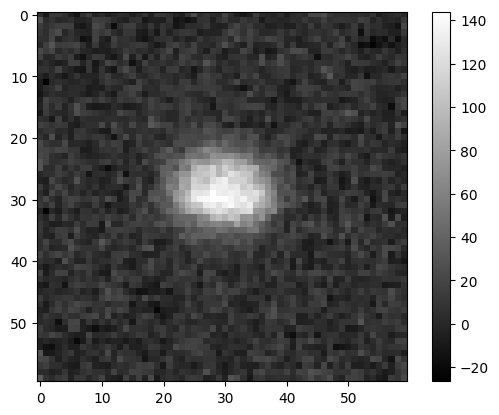

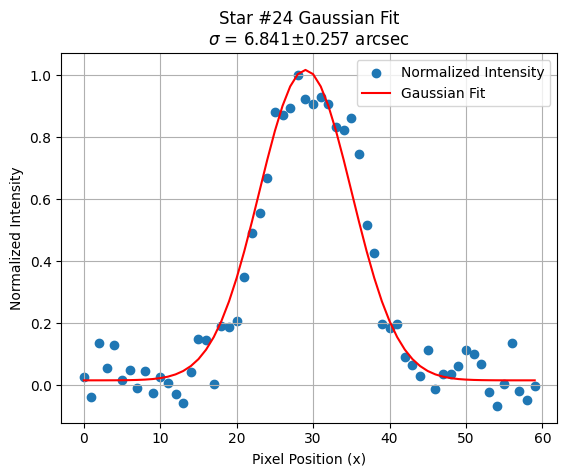

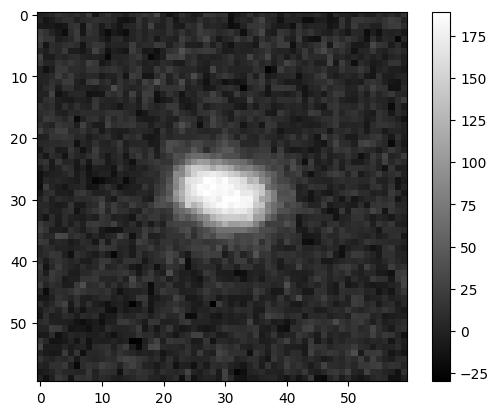

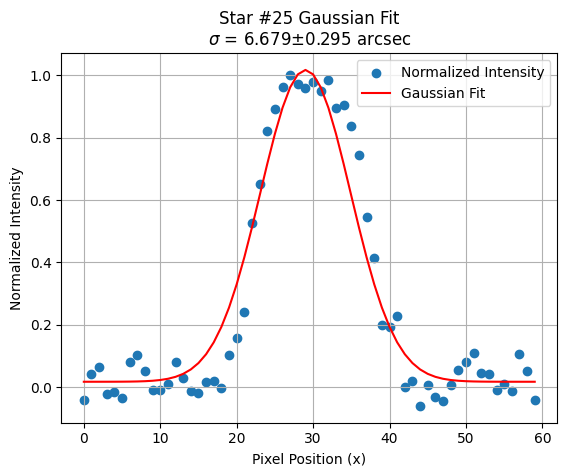

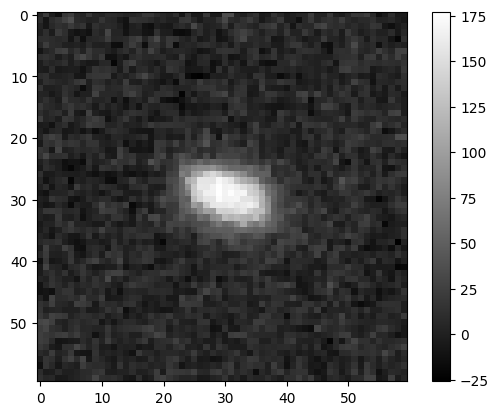

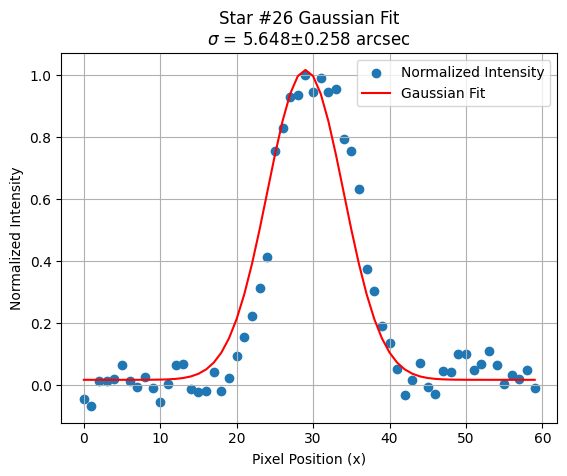

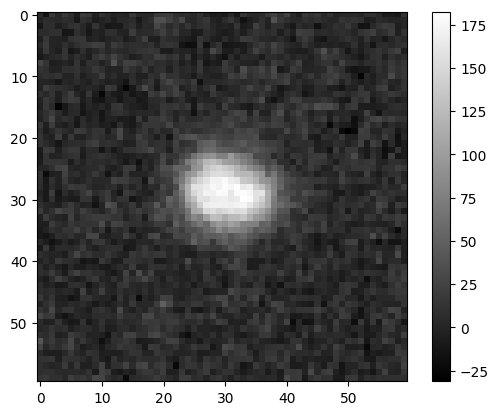

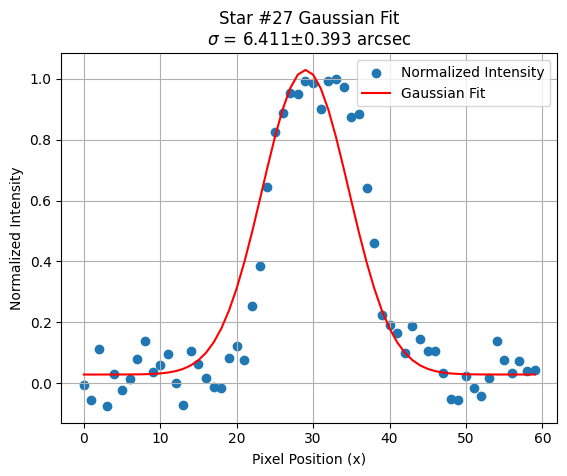

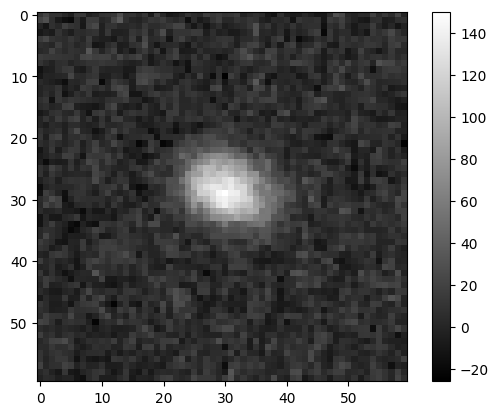

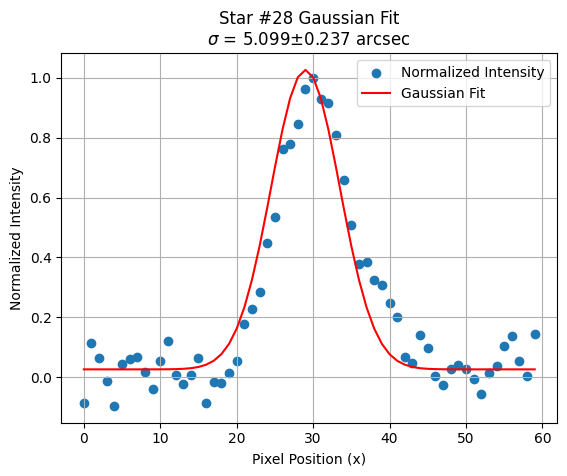

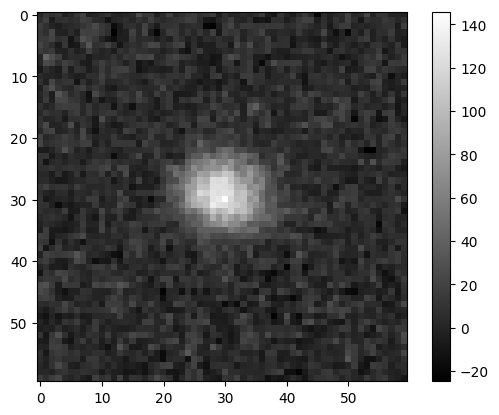

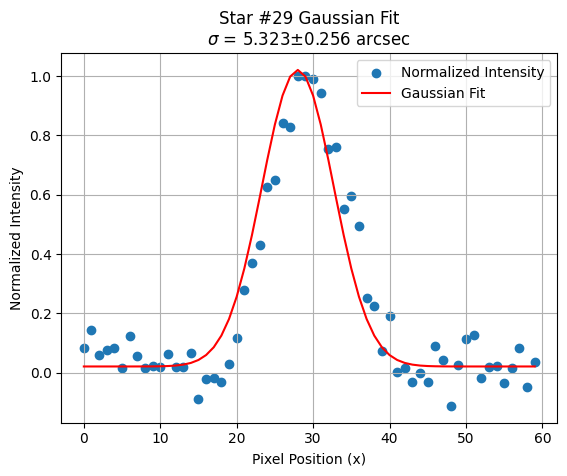

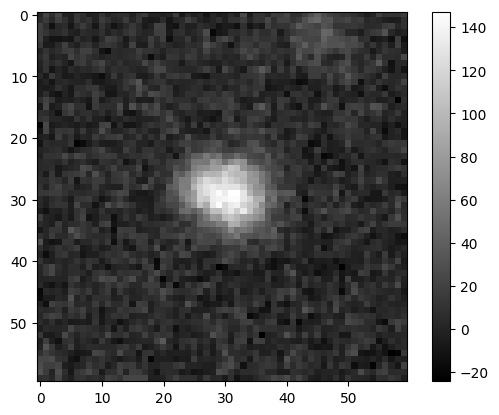

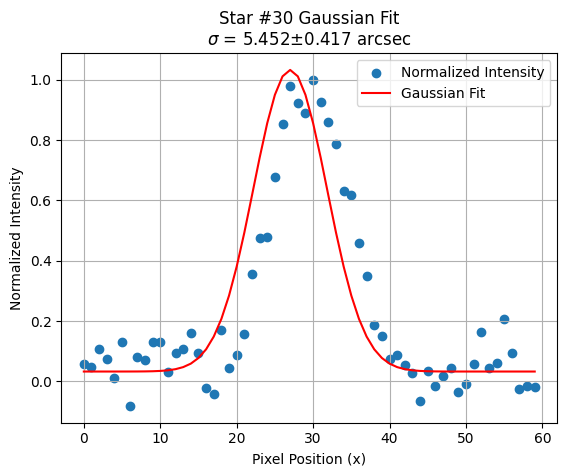

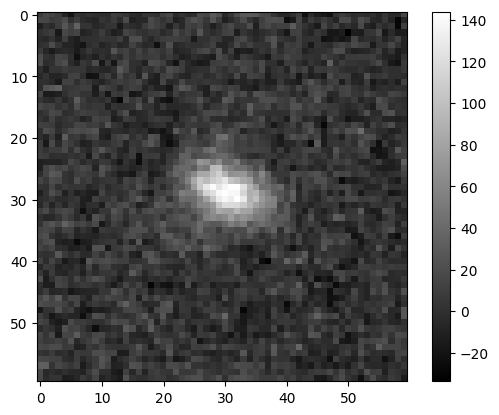

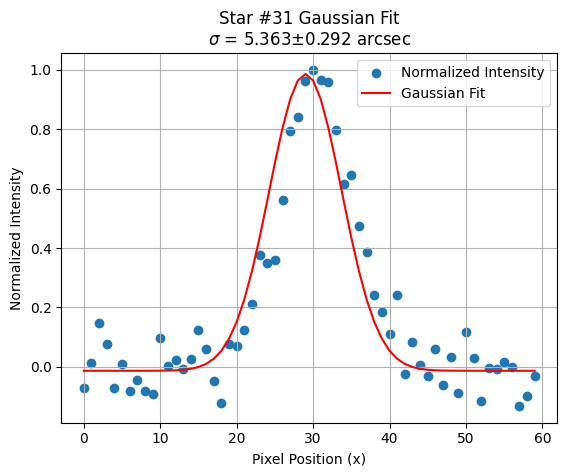

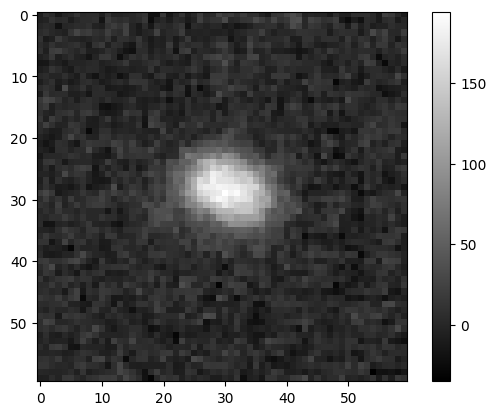

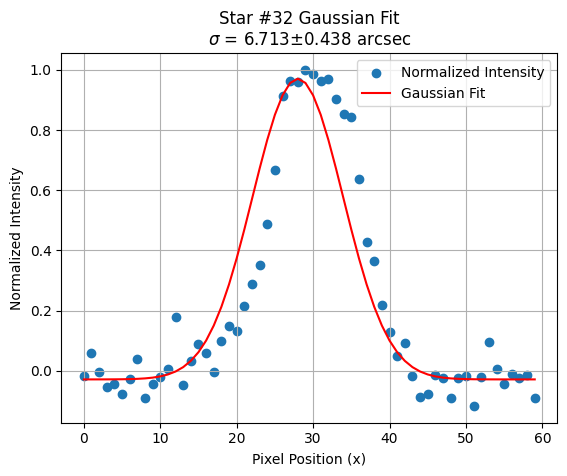

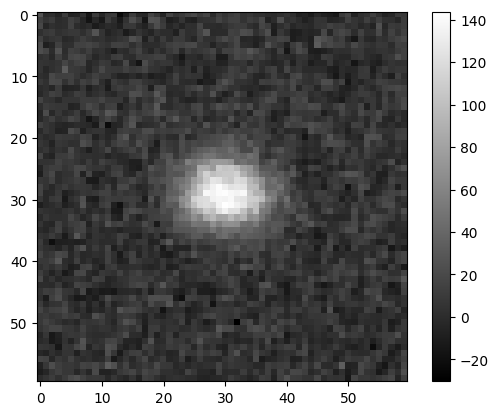

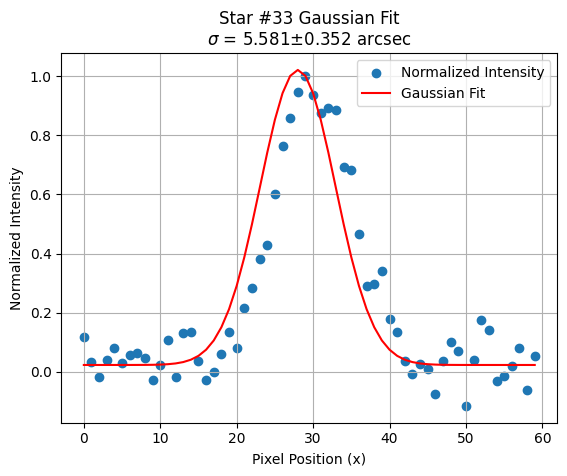

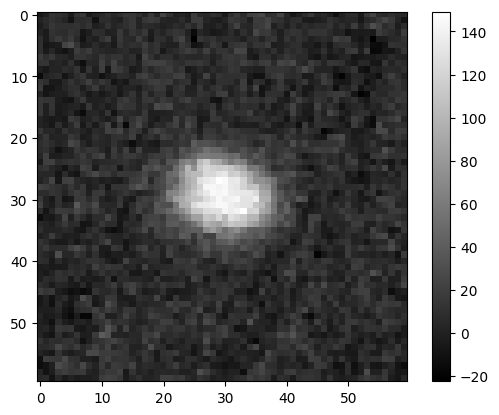

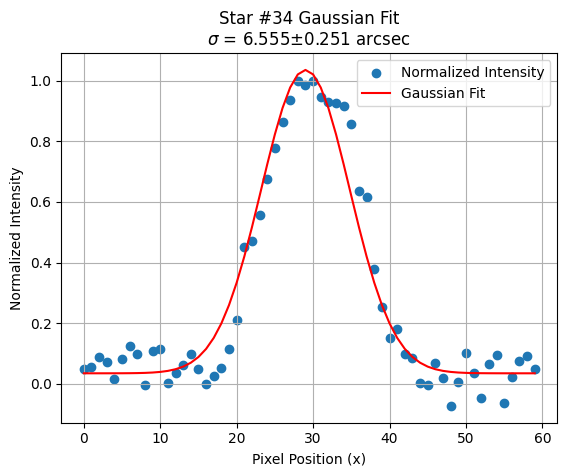

In [163]:
for i in range(len(loc_x)):
    star_0_img=crop_around(data, int(loc_x[i]), img_len_y - int(loc_y[i]))

    #corrected_pic_print
    plt.imshow(star_0_img, cmap='gray')
    plt.colorbar()
    plt.show()

    #curve_fit_setup

    x_data=np.arange(0,60)
    intensity=star_0_img[0:100][int(centeroid(star_0_img)[0])]
    max_intensity=intensity.max()
    intensity=intensity/max_intensity

    def gauss(x,a,b):
        return np.exp(-a * (x-centeroid(star_0_img)[0])**2)+b

    popt, pcov=curve_fit(gauss,x_data,intensity)
    delta_a=(pcov[0][0])**(1/2)
    sigma_pix=(popt[0]**(-1)/2)**(0.5)
    delta_sigma_pix=(sigma_pix**3)*delta_a
    sigma=sigma_pix*arcsec_per_pixel
    delta_sigma=delta_sigma_pix*arcsec_per_pixel
    sigma_hist=np.append(sigma_hist,sigma)
    delta_sigma_hist=np.append(delta_sigma_hist,delta_sigma)

    # intensity profile for one star
    plt.figure()
    plt.scatter(x_data, intensity, label="Normalized Intensity")
    plt.plot(x_data, gauss(x_data, *popt), color='red', label="Gaussian Fit")
    plt.xlabel("Pixel Position (x)")
    plt.ylabel("Normalized Intensity")
    plt.title(f"Star #{i+1} Gaussian Fit\n$\sigma$ = {sigma:.3f}±{delta_sigma:.3f} arcsec")
    plt.legend()
    plt.grid(True)
    plt.show()

Mean Gaussian Width (σ): 7.5921 arcsec
Standard Deviation: 1.7421 arcsec
Mean Uncertainty (Δσ): 0.3919 arcsec


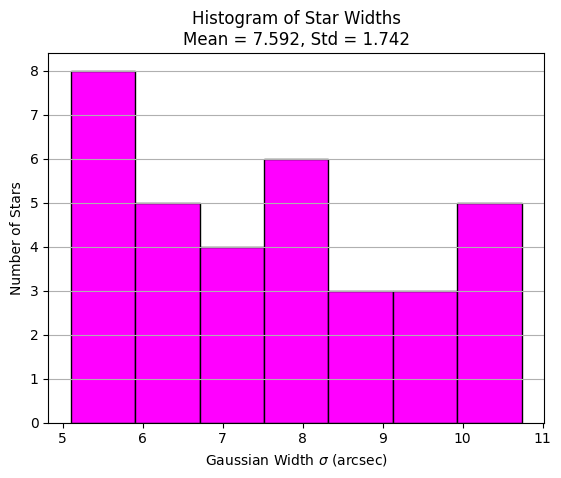

In [ ]:
# statistics
mean_sigma = np.mean(sigma_hist)
std_sigma = np.std(sigma_hist)
mean_delta_sigma = np.mean(delta_sigma_hist)

print("Mean Gaussian Width (σ): {:.4f} arcsec".format(mean_sigma))
print("Standard Deviation: {:.4f} arcsec".format(std_sigma))
print("Mean Uncertainty (Δσ): {:.4f} arcsec".format(mean_delta_sigma))

# histogram
plt.figure()
plt.hist(sigma_hist, bins='auto', color='magenta', edgecolor='black')
plt.xlabel("Gaussian Width $\sigma$ (arcsec)")
plt.ylabel("Number of Stars")
plt.title(f"Histogram of Star Widths\nMean = {mean_sigma:.3f}, Std = {std_sigma:.3f}")
plt.grid(axis='y')
plt.show()


# Background Magnitude

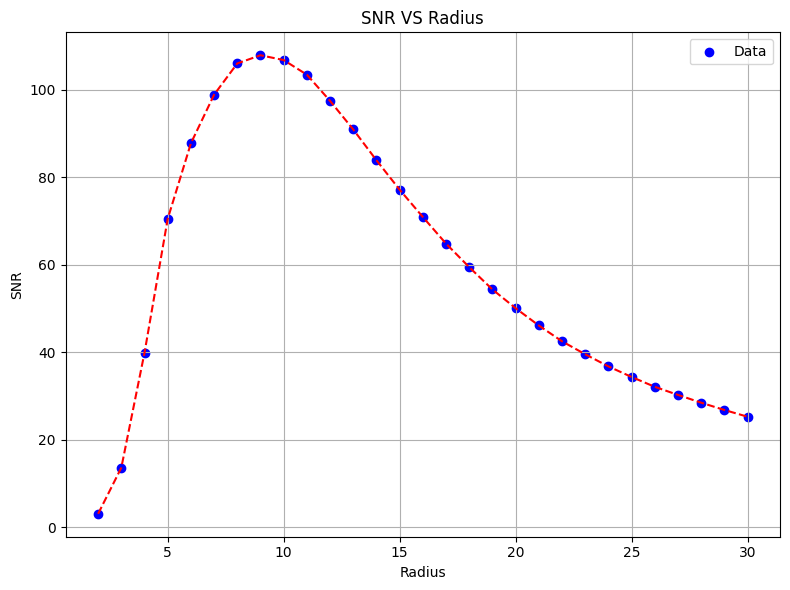

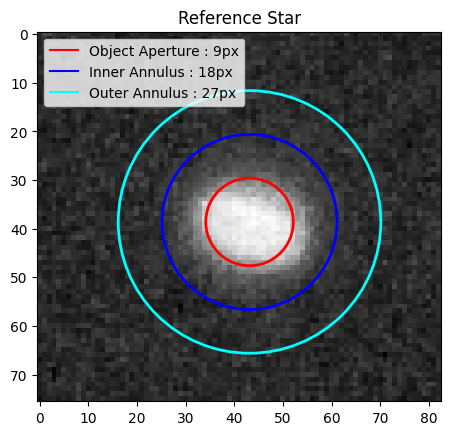

SNR =  107.87385848301871


In [ ]:
reference_photometry = get_photometry_magnitude(data, reference_center_ref)
reference_center_plot = (reference_center[0] + 2*reference_photometry[2], reference_center[1] + 2*reference_photometry[2])
fig, ax = plt.subplots()
ax.imshow(data[1690-2*reference_photometry[2] : 1730+ 2*reference_photometry[2], 1164-2*reference_photometry[2]:1211+2*reference_photometry[2]], cmap="gray")
ax.add_patch(mpl.patches.Circle(reference_center_plot, reference_photometry[2], color="red", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(reference_center_plot, 2*reference_photometry[2], color="blue", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(reference_center_plot, 3*reference_photometry[2], color="cyan", fill=False, lw=2))
ax.plot([], [], color="red", label=f"Object Aperture : {reference_photometry[2]}px")
ax.plot([], [], color="blue", label=f"Inner Annulus : {2 * reference_photometry[2]}px")
ax.plot([], [], color="cyan", label=f"Outer Annulus : {3 * reference_photometry[2]}px")
ax.legend()
ax.set_title("Reference Star")
plt.show()
print("SNR = ", reference_photometry[3])

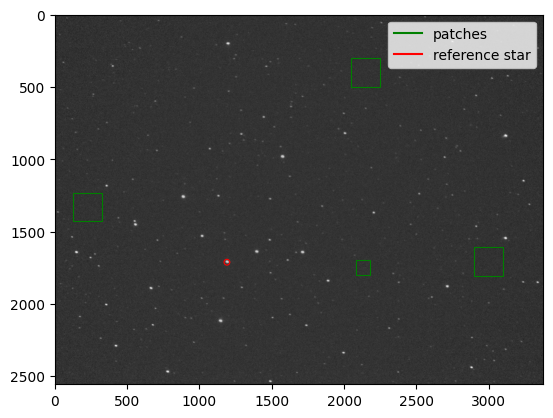

In [ ]:
fig, ax = plt.subplots()
ax.imshow(data, cmap='gray')
ax.add_patch(mpl.patches.Rectangle(
    (123, 1230), 200, 200, lw=0.8, color="green", fill=False, clip_on=False))
ax.add_patch(mpl.patches.Rectangle(
    (2080, 1700), 100, 100, lw=0.8, color="green", fill=False, clip_on=False))
ax.add_patch(mpl.patches.Rectangle(
    (2050, 300), 200, 200, lw=0.8, color="green", fill=False, clip_on=False))
ax.add_patch(mpl.patches.Rectangle(
    (2900, 1610), 200, 200, lw=0.8, color="green", fill=False, clip_on=False))
ax.add_patch(mpl.patches.Circle(
    (1190, 1712), 20, lw=0.8, color="red", fill=False, clip_on=False))
ax.plot([], color="green", label="patches")
ax.plot([], color="red", label="reference star")
ax.legend()
plt.show()

In [167]:
area_mag1 = (reference_mag - 2.5 * np.log(np.median(data[1230:1431, 123:324]) / arcsec_squared_per_pixel) 
            - reference_photometry[0])
area_mag2 = (reference_mag - 2.5 * np.log(np.median(data[1700:1801, 2080:2181]) / arcsec_squared_per_pixel)
            - reference_photometry[0])
area_mag3 = (reference_mag - 2.5 * np.log(np.median(data[300:501, 2050:2251]) / arcsec_squared_per_pixel)
            - reference_photometry[0])
area_mag_4 = (reference_mag - 2.5 * np.log(np.median(data[1610:1811, 2900:3101]) / arcsec_squared_per_pixel)
            - reference_photometry[0])

print('Area 1 magnitude: ', area_mag1)
print('Area 2 magnitude: ', area_mag2)
print('Area 3 magnitude: ', area_mag3)
print('Area 4 magnitude: ', area_mag_4)
print("Average Area magnitude: ", np.mean([area_mag1, area_mag2, area_mag3, area_mag_4]))
print("Error: ", np.std([area_mag1, area_mag2, area_mag3, area_mag_4]))

Area 1 magnitude:  15.605094288576115
Area 2 magnitude:  15.276144028543076
Area 3 magnitude:  15.615415353176648
Area 4 magnitude:  16.044459230359063
Average Area magnitude:  15.635278225163727
Error:  0.2728149876319693


# Limiting Magnitude

In [ ]:
import cupy as cp
from scipy.ndimage import maximum_filter
from tqdm import tqdm

def center_of_mass_cp(data):
    normalized_data = data / cp.max(data)
    y, x = cp.ogrid[0: data.shape[-2], 0: data.shape[-1]]
    while len(data.shape) > len(x.shape):
        x = cp.expand_dims(x, axis=0)
        y = cp.expand_dims(y, axis=0)
    first_moment_x = x * normalized_data
    first_moment_y = y * normalized_data
    mean_mass = cp.mean(normalized_data, axis=(-2, -1))
    return (cp.mean(first_moment_x, axis=(-2, -1)) / mean_mass,
            cp.mean(first_moment_y, axis=(-2, -1)) / mean_mass)

def get_photometry_magnitude_cp(data, center, radius_min=2, radius_max=30, gain=1, readnoise=1):
    y, x = cp.ogrid[0: data.shape[-2], 0: data.shape[-1]]
    dist = cp.sqrt((x - center[0])**2 + (y - center[1])**2)
    max_snr = 0
    for radius in range(radius_min, radius_max + 1):
        star_data = data[dist <= radius]
        sum_brightness = cp.sum(star_data)
        background_data = data[(2 * radius < dist) & (dist < 3 * radius)]
        background_brightness = cp.median(background_data) * star_data.size
        background_noise = sum_brightness
        corrected_brightness = sum_brightness - background_brightness
        noise = cp.sqrt((background_noise / gain) + (star_data.size * readnoise)**2)
        snr = corrected_brightness / gain / noise
        if snr > max_snr:
            max_snr = snr
            best_radius = radius
            best_brightness = corrected_brightness
    best_uncertainty = 1.08 / max_snr
    return float(-2.5 * cp.log10(best_brightness)), float(best_uncertainty), best_radius, float(max_snr)

hdu = fits.open("final_stacked_image.fits")
image_np = hdu[0].data.astype(np.float32)
image = cp.array(image_np)

# Detect bright points (local maxima)
threshold = np.percentile(image_np, 99)
local_max = (image_np == maximum_filter(image_np, size=5))
candidates = np.argwhere((image_np > threshold) & local_max)

detected_stars = []
for y, x in tqdm(candidates, desc="Evaluating stars"):
    try:
        cutout = image[y-15:y+16, x-15:x+16]
        if cutout.shape != (31, 31):
            continue
        cx, cy = center_of_mass_cp(cutout)
        real_x = x - 15 + float(cx)
        real_y = y - 15 + float(cy)
        mag, unc, r, snr = get_photometry_magnitude_cp(image, (real_x, real_y))
        if snr > 5:
            detected_stars.append((mag, real_x, real_y, snr))
    except:
        continue

detected_stars.sort(reverse=True)

In [200]:
for mag, x, y, snr in detected_stars:
    if snr > 15 :
        print(f"Mag: {mag+(reference_mag - reference_photometry[0]) :.2f}, SNR: {snr:.2f}, Pos: ({x:.1f}, {y:.1f})")

Mag: 6.77, SNR: 23.83, Pos: (573.7, 1439.6)
Mag: 6.79, SNR: 29.39, Pos: (3103.4, 858.0)
Mag: 6.80, SNR: 20.32, Pos: (1195.7, 1688.4)
Mag: 6.81, SNR: 20.17, Pos: (1151.7, 2094.5)
Mag: 6.84, SNR: 21.04, Pos: (907.7, 1251.9)
Mag: 6.84, SNR: 25.96, Pos: (897.0, 1278.5)
Mag: 6.85, SNR: 19.50, Pos: (1190.4, 1687.0)
Mag: 6.86, SNR: 39.04, Pos: (1148.4, 2104.0)
Mag: 6.86, SNR: 25.40, Pos: (1148.2, 2139.4)
Mag: 6.87, SNR: 38.34, Pos: (1145.5, 2103.1)
Mag: 6.87, SNR: 25.32, Pos: (3092.0, 847.9)
Mag: 6.89, SNR: 18.81, Pos: (3096.9, 819.4)
Mag: 6.89, SNR: 23.07, Pos: (907.2, 1255.4)
Mag: 6.89, SNR: 18.69, Pos: (1149.1, 2144.2)
Mag: 6.89, SNR: 18.69, Pos: (3086.1, 845.3)
Mag: 6.90, SNR: 19.89, Pos: (1192.5, 1734.6)
Mag: 6.90, SNR: 18.43, Pos: (1118.6, 2117.7)
Mag: 6.93, SNR: 24.00, Pos: (871.8, 1277.0)
Mag: 6.94, SNR: 17.88, Pos: (1549.1, 994.0)
Mag: 6.94, SNR: 22.07, Pos: (3088.8, 836.0)
Mag: 6.95, SNR: 17.75, Pos: (3090.5, 856.4)
Mag: 6.95, SNR: 17.75, Pos: (1188.8, 1736.8)
Mag: 6.95, SNR: 27.59,

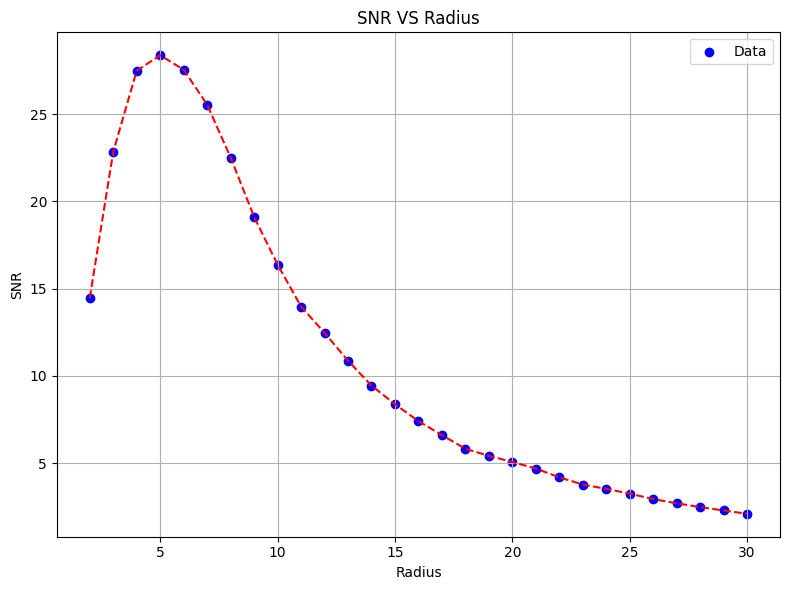

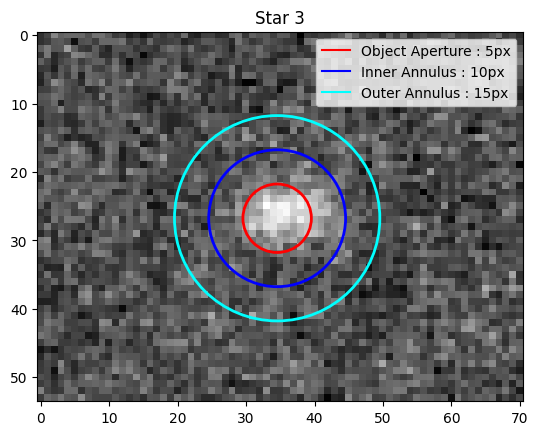

SNR =  28.37315059977592
Star 3: 10.088792585879531, Error = 0.03935878421736781


In [197]:
#Mag: 10.62, SNR: 26.16, Pos: (876.0, 158.7)
star3_center = center_of_mass(data[142:176, 847:898])
star3_center_ref = (star3_center[0] + 847, star3_center[1] + 142)
star3_photometry = get_photometry_magnitude(data, star3_center_ref)

star3_center_plot = (star3_center[0] + 2*star3_photometry[2], star3_center[1] + 2*star3_photometry[2])
fig, ax = plt.subplots()
ax.imshow(data[142-2*star3_photometry[2] : 176+ 2*star3_photometry[2], 847-2*star3_photometry[2]:898+2*star3_photometry[2]], cmap="gray")
ax.add_patch(mpl.patches.Circle(star3_center_plot, star3_photometry[2], color="red", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(star3_center_plot, 2*star3_photometry[2], color="blue", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(star3_center_plot, 3*star3_photometry[2], color="cyan", fill=False, lw=2))
ax.plot([], [], color="red", label=f"Object Aperture : {star3_photometry[2]}px")
ax.plot([], [], color="blue", label=f"Inner Annulus : {2 * star3_photometry[2]}px")
ax.plot([], [], color="cyan", label=f"Outer Annulus : {3 * star3_photometry[2]}px")
ax.legend()
ax.set_title("Star 3")
plt.show()
print("SNR = ", star3_photometry[3])
print(f"Star 3: {reference_mag + star3_photometry[0] - reference_photometry[0]}, Error = "
      f"{np.sqrt(reference_photometry[1]**2 + star3_photometry[1]**2)}")

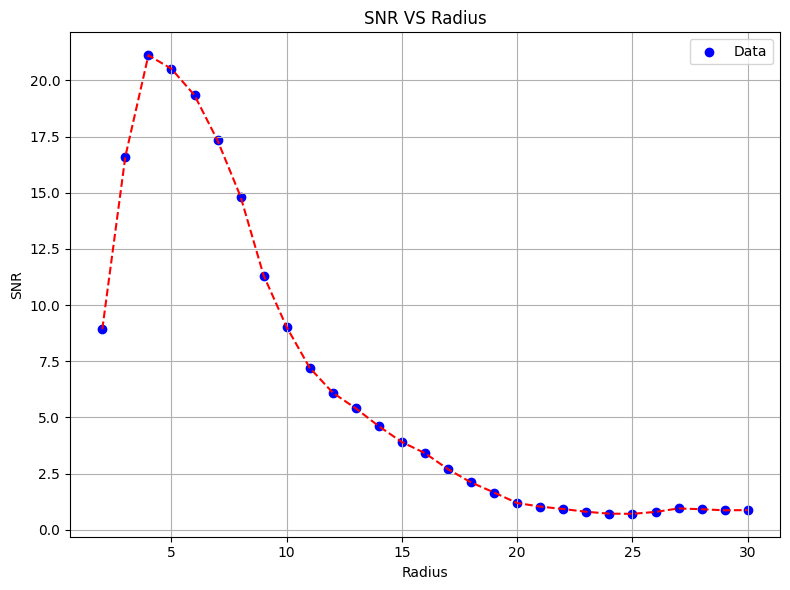

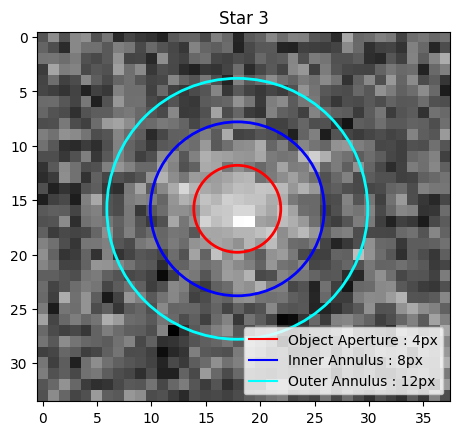

SNR =  21.115934247925242
Star 3: 10.888682580249345, Error = 0.05211687602737639


In [201]:
#Mag: 10.62, SNR: 26.16, Pos: (876.0, 158.7)
star4_center = center_of_mass(data[566:584, 888:910])
star4_center_ref = (star4_center[0] + 888, star4_center[1] + 566)
star4_photometry = get_photometry_magnitude(data, star4_center_ref)

star4_center_plot = (star4_center[0] + 2*star4_photometry[2], star4_center[1] + 2*star4_photometry[2])
fig, ax = plt.subplots()
ax.imshow(data[566-2*star4_photometry[2] : 584+ 2*star4_photometry[2], 888-2*star4_photometry[2]:910+2*star4_photometry[2]], cmap="gray")
ax.add_patch(mpl.patches.Circle(star4_center_plot, star4_photometry[2], color="red", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(star4_center_plot, 2*star4_photometry[2], color="blue", fill=False, lw=2))
ax.add_patch(mpl.patches.Circle(star4_center_plot, 3*star4_photometry[2], color="cyan", fill=False, lw=2))
ax.plot([], [], color="red", label=f"Object Aperture : {star4_photometry[2]}px")
ax.plot([], [], color="blue", label=f"Inner Annulus : {2 * star4_photometry[2]}px")
ax.plot([], [], color="cyan", label=f"Outer Annulus : {3 * star4_photometry[2]}px")
ax.legend()
ax.set_title("Star 3")
plt.show()
print("SNR = ", star4_photometry[3])
print(f"Star 3: {reference_mag + star4_photometry[0] - reference_photometry[0]}, Error = "
      f"{np.sqrt(reference_photometry[1]**2 + star4_photometry[1]**2)}")

## Theoretical Limiting Magnitude

In [203]:
bps1 = np.median(data[1230:1431, 123:324])
bps2 = np.median(data[1700:1801, 2080:2181])
bps3 = np.median(data[300:501, 2050:2251])
bps4 = np.median(data[1610:1811, 2900:3101])
background_per_pixel = np.mean([bps1, bps2, bps3, bps4])

snr_min = 3
sigma_pixels = mean_sigma / arcsec_per_pixel
r = 3 * sigma_pixels
N = math.pi * r**2
B = background_per_pixel * N
gain = 1
read_noise = 1
noise = np.sqrt((B / gain) + (N * read_noise)**2)
F_lim = snr_min * noise

F_ref = reference_photometry[4]

magnitude_limit = reference_mag - 2.5 * math.log10(F_lim / F_ref)


In [169]:
magnitude_limit

9.747484135452401

In [207]:
# uncertainty 
bps_values = [bps1, bps2, bps3, bps4]
background_std = np.std(bps_values)
sigma_B = background_std * N

# Noise propagation 
d_noise_dB = 1 / (2 * noise * gain)
sigma_noise = d_noise_dB * sigma_B

sigma_F_lim = snr_min * sigma_noise

sigma_mag_lim = (2.5 / np.log(10)) * (sigma_F_lim / F_lim)

print(f"Theoretical Limiting Magnitude: {magnitude_limit:.3f} ± {sigma_mag_lim:.5f}")


Theoretical Limiting Magnitude: 9.747 ± 0.00020


# Star Magnitude

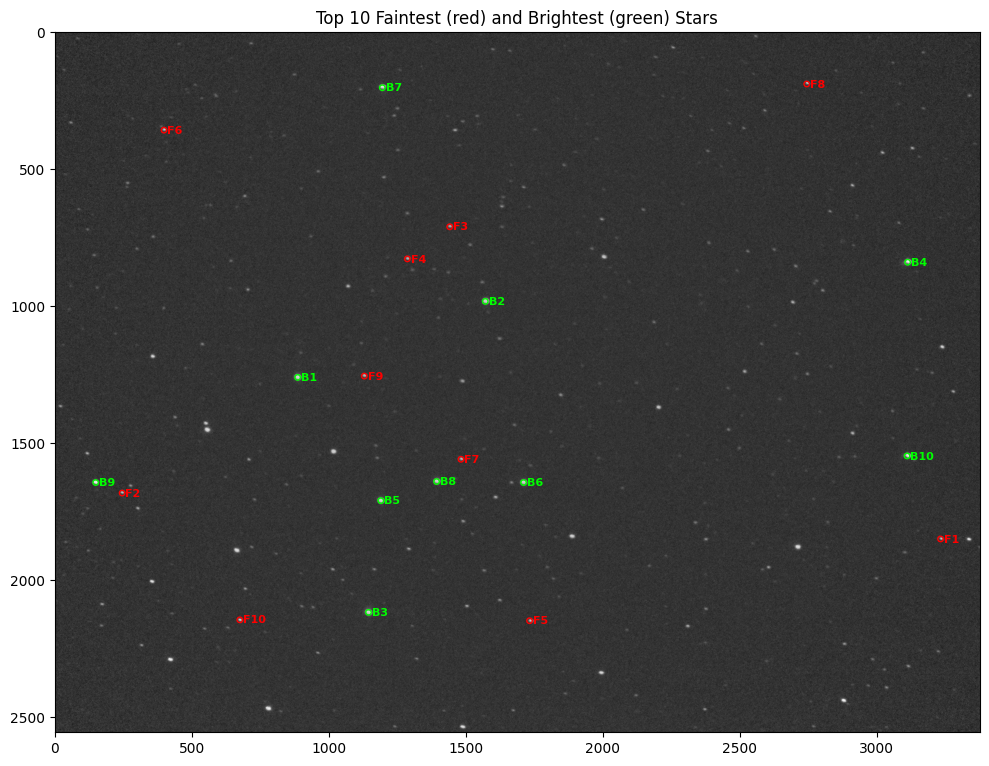

 ID  Magnitude    ±    SNR      X      Y   Type
 F1       8.84 0.02  70.95 3233.6 1850.7  Faint
 F2       8.60 0.02  70.43  245.2 1682.9  Faint
 F3       8.58 0.02  72.05 1441.3  710.9  Faint
 F4       8.58 0.02  72.35 1286.6  828.0  Faint
 F5       8.56 0.02  72.27 1732.8 2149.2  Faint
 F6       8.56 0.02  72.31  397.9  357.8  Faint
 F7       8.55 0.02  71.92 1482.4 1559.7  Faint
 F8       8.52 0.01  75.09 2744.9  189.4  Faint
 F9       8.50 0.01  76.32 1129.4 1256.0  Faint
F10       8.49 0.01  76.18  674.8 2146.0  Faint
 B1       7.13 0.01 112.53  886.0 1260.8 Bright
 B2       7.16 0.01 110.65 1571.1  983.1 Bright
 B3       7.16 0.01 108.38 1144.6 2118.7 Bright
 B4       7.22 0.01 119.56 3113.2  840.3 Bright
 B5       7.35 0.01 108.40 1189.7 1710.8 Bright
 B6       7.36 0.01 108.05 1710.8 1644.6 Bright
 B7       7.36 0.01 109.34 1195.2  203.0 Bright
 B8       7.36 0.01 107.95 1393.3 1641.1 Bright
 B9       7.46 0.01 115.83  148.6 1644.6 Bright
B10       7.48 0.01 114.39 3111.1 1547.5

In [208]:
from matplotlib.patches import Circle

def mag_uncertainty(snr):
    return 2.5 / np.log(10) / snr


# Settings
top_n = 10
min_dist = 10  # pixels
circle_radius = 10  # fixed radius for drawing circles

# remove duplicates
def too_close(new_x, new_y, selected_coords, min_dist):
    for x0, y0 in selected_coords:
        if np.hypot(new_x - x0, new_y - y0) < min_dist:
            return True
    return False

corrected_stars = [
    (mag + (reference_mag - reference_photometry[0]), x, y, snr)
    for mag, x, y, snr in detected_stars if snr > 70
]

faint_candidates = sorted(corrected_stars, reverse=True) 
faint_selected, faint_coords = [], []

for star in faint_candidates:
    _, x, y, _ = star
    if not too_close(x, y, faint_coords, min_dist):
        faint_selected.append(star)
        faint_coords.append((x, y))
    if len(faint_selected) >= top_n:
        break

bright_candidates = sorted(corrected_stars) 
bright_selected, bright_coords = [], []

for star in bright_candidates:
    _, x, y, _ = star
    if not too_close(x, y, faint_coords + bright_coords, min_dist):
        bright_selected.append(star)
        bright_coords.append((x, y))
    if len(bright_selected) >= top_n:
        break

plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='gray')

# Faint stars
for i, (mag, x, y, snr) in enumerate(faint_selected, 1):
    circle = Circle((x, y), circle_radius, edgecolor='red', facecolor='none', linewidth=1)
    plt.gca().add_patch(circle)
    plt.text(x + circle_radius + 2, y + circle_radius + 2, f"F{i}", color='red', fontsize=8, weight='bold')

# Bright stars 
for i, (mag, x, y, snr) in enumerate(bright_selected, 1):
    circle = Circle((x, y), circle_radius, edgecolor='lime', facecolor='none', linewidth=1)
    plt.gca().add_patch(circle)
    plt.text(x + circle_radius + 2, y + circle_radius + 2, f"B{i}", color='lime', fontsize=8, weight='bold')

plt.title(f"Top {top_n} Faintest (red) and Brightest (green) Stars")
plt.tight_layout()
plt.show()

combined = []

for i, (mag, x, y, snr) in enumerate(faint_selected, 1):
    mag_err = mag_uncertainty(snr)
    combined.append({
        "ID": f"F{i}",
        "Magnitude": round(mag, 2),
        "±": round(mag_err, 2),
        "SNR": round(snr, 2),
        "X": round(x, 1),
        "Y": round(y, 1),
        "Type": "Faint"
    })

for i, (mag, x, y, snr) in enumerate(bright_selected, 1):
    combined.append({
        "ID": f"B{i}",
        "Magnitude": round(mag, 2),
        "±": round(mag_err, 2),
        "SNR": round(snr, 2),
        "X": round(x, 1),
        "Y": round(y, 1),
        "Type": "Bright"
    })

df = pd.DataFrame(combined)
print(df.to_string(index=False))


# Background Modeling

In [171]:
patches = [
    (123, 324, 1230, 1431),
    (2080, 2181, 1700, 1801),
    (2050, 2251, 300, 501),
    (2900, 3101, 1610, 1811),
    (100, 422, 72, 254),
    (957, 1172, 29, 175),
    (1751, 1964, 64, 188),
    (685, 809, 1015, 1214),
    (1268, 1434, 1091,1217),
    (2306, 2526, 1056, 1211),
    (730, 864, 1355, 1486),
    (1320, 1469, 1328, 1495),
    (2098, 271, 1744, 1882),
    (82, 350, 2299, 2512),
    (1476, 1749, 2190, 2400),
    (2470, 2807, 2065, 2252),
    (3144, 3285, 1986, 2200)
]


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def background_model(coords, a, b, c):
    x, y = coords
    return a * x + b * y + c

def fit_background(image, patches):
    x_coords = []
    y_coords = []
    brightnesses = []

    for (x1, x2, y1, y2) in patches:
        patch = image[y1:y2, x1:x2]
        mean_brightness = np.mean(patch)

        if np.isnan(mean_brightness) or np.isinf(mean_brightness):
            continue  # skip invalid patches

        # Center of patch
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        x_coords.append(cx)
        y_coords.append(cy)
        brightnesses.append(mean_brightness)

    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    brightnesses = np.array(brightnesses)

    # safety filter 
    valid = (
        ~np.isnan(x_coords) & ~np.isnan(y_coords) & ~np.isnan(brightnesses) &
        ~np.isinf(x_coords) & ~np.isinf(y_coords) & ~np.isinf(brightnesses)
    )
    x_coords = x_coords[valid]
    y_coords = y_coords[valid]
    brightnesses = brightnesses[valid]

    if len(x_coords) < 3:
        raise ValueError("Not enough valid background patches to fit the model.")

    # Fit the model
    popt, _ = curve_fit(background_model, (x_coords, y_coords), brightnesses)

    return popt 


C:\Users\ExoGame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ExoGame\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Background model: z = -0.0002*x + 0.0004*y + 4.5674


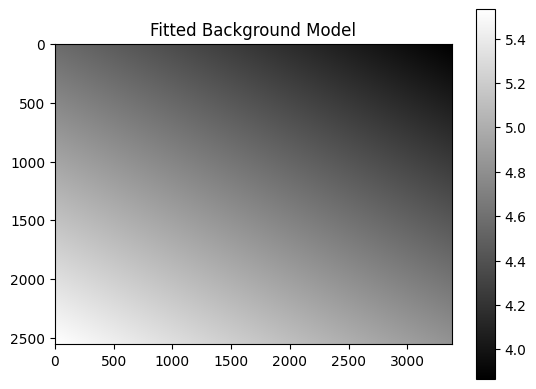

In [ ]:
params = fit_background(data, patches)
a, b, c = params
print(f"Background model: z = {a:.4f}*x + {b:.4f}*y + {c:.4f}")

h, w = data.shape
x = np.arange(w)
y = np.arange(h)
X, Y = np.meshgrid(x, y)

Z = a * X + b * Y + c  

plt.imshow(Z, cmap="gray")
plt.title("Fitted Background Model")
plt.colorbar()
plt.show()


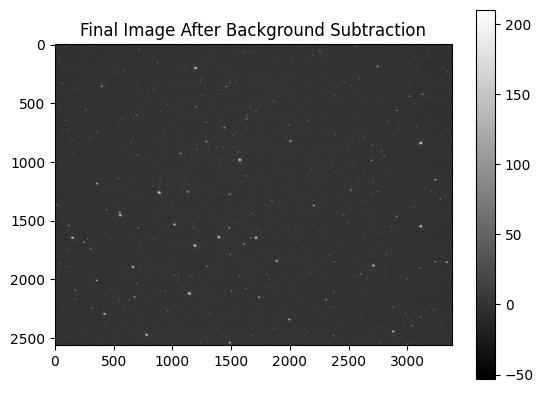

In [174]:
corrected_image = data - Z
plt.imshow(corrected_image, cmap="gray")
plt.title("Final Image After Background Subtraction")
plt.colorbar()
plt.show()
